# 手写阿拉伯数字辨识 完整版

## 载入套件

In [60]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

## 设定参数

In [61]:
PATH_DATASETS = "" # 预设路径
BATCH_SIZE = 1024  # 批量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

## 步骤1：载入 MNIST 手写阿拉伯数字资料

In [62]:
# 下载 MNIST 手写阿拉伯数字 训练资料
train_ds = MNIST(PATH_DATASETS, train=True, download=True, 
                 transform=transforms.ToTensor())

# 下载测试资料
test_ds = MNIST(PATH_DATASETS, train=False, download=True, 
                 transform=transforms.ToTensor())

# 训练/测试资料的维度
print(train_ds.data.shape, test_ds.data.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


In [63]:
# 删除 log 目录
import os
import shutil

dirpath = './runs_2'
if os.path.exists(dirpath) and os.path.isdir(dirpath):
    shutil.rmtree(dirpath)

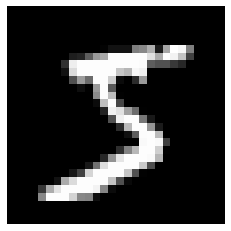

In [64]:
# 显示第1张图片图像
import matplotlib.pyplot as plt

# 第一笔资料
X = train_ds.data[0]

# 绘制点阵图，cmap='gray':灰阶
plt.imshow(X.reshape(28,28), cmap='gray')

# 隐藏刻度
plt.axis('off') 

# 显示图形
plt.show() 

In [65]:
from torch.utils.tensorboard import SummaryWriter

# 设定工作记录档目录
writer = SummaryWriter('runs_2/mnist_experiment_1')

In [66]:
# create grid of images
import torchvision

img_grid = torchvision.utils.make_grid(X.reshape(28,28))
writer.add_image('First image', img_grid)

## 步骤2：资料清理，此步骤无需进行

## 步骤3：特征工程，此步骤无需进行

## 步骤4：资料分割，此步骤无需进行，载入MNIST资料时，已经切割好了

## 步骤5：建立模型结构

In [67]:
# 建立模型
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28 * 28, 256), 
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 10), 
    # 使用nn.CrossEntropyLoss()时，不需要将输出经过softmax层，否则计算的损失会有误
    # torch.nn.Softmax(dim=1)
).to(device)

## 步骤6：结合训练资料及模型，进行模型训练

In [68]:
epochs = 5
lr=0.1

# 建立 DataLoader
train_loader = DataLoader(train_ds, batch_size=600)

# 设定优化器(optimizer)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

model.train()
loss_list = []  
n=0
for epoch in range(1, epochs + 1):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
#         if batch_idx == 0 and epoch == 1: print(data[0])

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        # 将损失写入log
        n+=1
        writer.add_scalar("Loss/train", loss, n)
        
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            loss_list.append(loss.item())
            batch = batch_idx * len(data)
            data_count = len(train_loader.dataset)
            percentage = (100. * batch_idx / len(train_loader))
            print(f'Epoch {epoch}: [{batch:5d} / {data_count}] ({percentage:.0f} %)' +
                  f'  Loss: {loss.item():.6f}')

Epoch 1: [    0 / 60000] (0 %)  Loss: 2.271219
Epoch 1: [ 6000 / 60000] (10 %)  Loss: 1.982283
Epoch 1: [12000 / 60000] (20 %)  Loss: 1.776822
Epoch 1: [18000 / 60000] (30 %)  Loss: 1.538974
Epoch 1: [24000 / 60000] (40 %)  Loss: 1.323098
Epoch 1: [30000 / 60000] (50 %)  Loss: 1.214961
Epoch 1: [36000 / 60000] (60 %)  Loss: 0.987811
Epoch 1: [42000 / 60000] (70 %)  Loss: 0.976054
Epoch 1: [48000 / 60000] (80 %)  Loss: 0.705115
Epoch 1: [54000 / 60000] (90 %)  Loss: 0.733142
Epoch 2: [    0 / 60000] (0 %)  Loss: 0.683233
Epoch 2: [ 6000 / 60000] (10 %)  Loss: 0.543707
Epoch 2: [12000 / 60000] (20 %)  Loss: 0.633048
Epoch 2: [18000 / 60000] (30 %)  Loss: 0.543870
Epoch 2: [24000 / 60000] (40 %)  Loss: 0.567609
Epoch 2: [30000 / 60000] (50 %)  Loss: 0.619578
Epoch 2: [36000 / 60000] (60 %)  Loss: 0.507021
Epoch 2: [42000 / 60000] (70 %)  Loss: 0.616504
Epoch 2: [48000 / 60000] (80 %)  Loss: 0.406397
Epoch 2: [54000 / 60000] (90 %)  Loss: 0.466917
Epoch 3: [    0 / 60000] (0 %)  Loss: 0.45

## 对训练过程的损失绘图

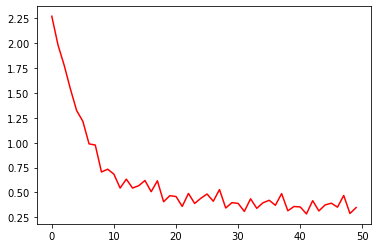

In [69]:
import matplotlib.pyplot as plt

plt.plot(loss_list, 'r')

In [70]:
writer.flush()
writer.close()